In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

In [5]:
using CSV, DataFrames

In [35]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :v => Float64,  #Swimming speed
        :theta => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :active => Bool,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64, #CheYP levels, probability of tumblingç
        :G => Float64,
        :λ => Float64,
        :P => Float64,
        :M => Float64,
        :mm => Float64,
        :F => Float64,
        :A => Float64
        
    ),

    model = Dict(

        :Dr_run => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        # :Yp0 => Float64,   #CheYP adapted = K
        :α => Float64,      #Total Yp pool
        :ωFrec => Float64,     #Basal switching frequency
        :Ky => Float64,         #CheA - CheY phosphorylation rate
        :Z => Float64,          #CheZ concentration
        :Kz => Float64,         #CheZ mediated dephosphorylation rate
        :Yy => Float64,         #Basa Yp leak
    ),

    # medium = Dict(
    #     :mm => Float64
    # ),

    agentODE = quote
    
        # mm = 0.02*exp(x*30^(-1))
        mm = 0.02*exp(x*30^(-2))
        # mm = 0.02*exp(x*30^(-3))
        # mm = 0.02*exp(x*30^(-5))

    

        F = ε0 + ε1 * methyl + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(((Ky * (α - K)) / (K * (Kz * Z + Yy))) - 1)        #Energia lliure en estat adaptat

        mx = (ε0 + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) - F0) / (- ε1)

        A = 1 / (1 + exp(F))    

        Yp = (Ky * A * α) / ((Ky * A) + (Kz * Z) + Yy)

        G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))      #CheYp segons activitat receptor

        dt(x) = active * vx  #Change position acording to constant speed afected by forces
        dt(y) = active * vy  
        dt(methyl) = -(1 / τm) * (methyl - mx)        #Methylation
        
    end,

    agentRule = quote
        v_run = v
        v_tumble = 0.25 

        speed = active ? v_run : v_tumble

        Dr_tumble = 6.2      
        Dr_total = active ? Dr_run : Dr_tumble



        if active 
            λ = ωFrec*exp(-G)
            P = 1 - exp(-λ * dt)
            
        else
            λ = ωFrec*exp(G)
            P = 1 - exp(-λ * dt)  
            
        end


        if active 
            λrt = ωFrec*exp(-G) 

            P_rt = 1 - exp(-λrt * dt)
            P = rand() 
                                                 #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
            if P < P_rt             #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                active = false
                vx = speed
                vy = speed
                theta += sqrt(2 * Dr_total * dt) * randn()           #Tumble = random reorientation
            else     #Si rate baixa 
                active = true
                vx = speed * cos(theta)
                vy = speed * sin(theta)
                theta += sqrt(2 * Dr_total * dt) * randn()       #Keep running, reorientation according to rotational difusion
            end

        elseif !active
            λtr = ωFrec*exp(G) *dt
            P_tr = 1 - exp(-λtr * dt)
            P = rand()

            if P < P_tr
                active = true
                vx = speed * cos(theta)
                vy = speed * sin(theta)
                theta += sqrt(2 * Dr_total * dt) * randn()
            else
                active = false
                vx = speed
                vy = speed
                theta += sqrt(2 * Dr_total * dt) * randn()
            end
            
        end

 
        #Avoid too large numbers of chemoattractant
        if x > 4000
            x = 3900
            theta = pi - theta
        end
    

        # if x < simBox[1,1]
        #     x = simBox[1,1]
        #     theta = pi - theta      
        # elseif x > simBox[1,2]
        #     x = simBox[1,2]
        #     theta = pi - theta
        # end
        # if y < simBox[2,1]
        #     y = simBox[2,1]
        #     theta = -theta
        # elseif y > simBox[2,2]
        #     y = simBox[2,2]
        #     theta = -theta
        # end

    end,

    # mediumODE = quote
    #     if @mediumInside()
    #         dt(mm) = 0.02*exp((x - com.simBox[1,1])*30^(-3 ))
    #     end
    # end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	M (Float64 agent)
	d (Float64 agent)
	active (Bool agent)
	v (Float64 agent)
	λ (Float64 agent)
	F (Float64 agent)
	fx (Float64 agent)
	mm (Float64 agent)
	A (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	P (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	W (Float64 agent)
	G (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	Z (Float64 model)
	Dr_run (Float64 model)
	Ka (Float64 model)
	ε3 (Float64 model)
	ε0 (Float64 model)
	Ky (Float64 model)
	Kz (Float64 model)
	K (Float64 model)
	ε2 (Float64 model)
	Nrec (Float64 model)
	τm (Float64 model)
	Yy (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)


UPDATE RULES
agentRule
 begin
    v_run = v
    v_tumble = 0.25
    speed = if active
            v_run
        else
            v_tumble
        end
    Dr_tumble = 6.2
    Dr_total = if active
     

In [37]:
com = Community(
    rods2DChemotaxis,
    N=100,
    dt=0.01,
    simBox=[0 40; 0 40.],  #change box
    NMedium=[200, 200],
)

m = 1/100
g = 1/10000
d = 1

com.Dr_run = 0.062

com.v = 20.0
# com.v = 10.0
# com.v = 5.0

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80
# com.τm = 5.0
# com.τm = 10.0
com.τm = 30.0
com.α   = 6.0

com.K = 2.0 

com.Ky = 100.0
com.Kz = 10.0
com.Z = 5.0
com.Yy = 0.1

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.methyl .= 0.0
com.Yp .= com.K

com.active = true

true

In [ ]:
using CSV, DataFrames

outfile = "dufour_python.csv"
data = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    active = Bool[],
    λ = Float64[],
    G = Float64[], 
    P = Float64[],
    M = Float64[],   
    Yp = Float64[],
    methyl = Float64[],
    F = Float64[]
)



steps = 1000000
loadToPlatform!(com, preallocateAgents=100)       #Preallocate agents = number of agents in community


for step in 1:steps
    step!(com)
    for i in 1:com.N
        push!(data, (
            step, 
            i,
            com.x[i],
            com.y[i],
            com.active[i],
            com.λ[i],
            com.G[i],
            com.P[i],
            com.mm[i],
            com.Yp[i],
            com.methyl[i],
            com.F[i]
        ))
    end
end

CSV.write(outfile, data)

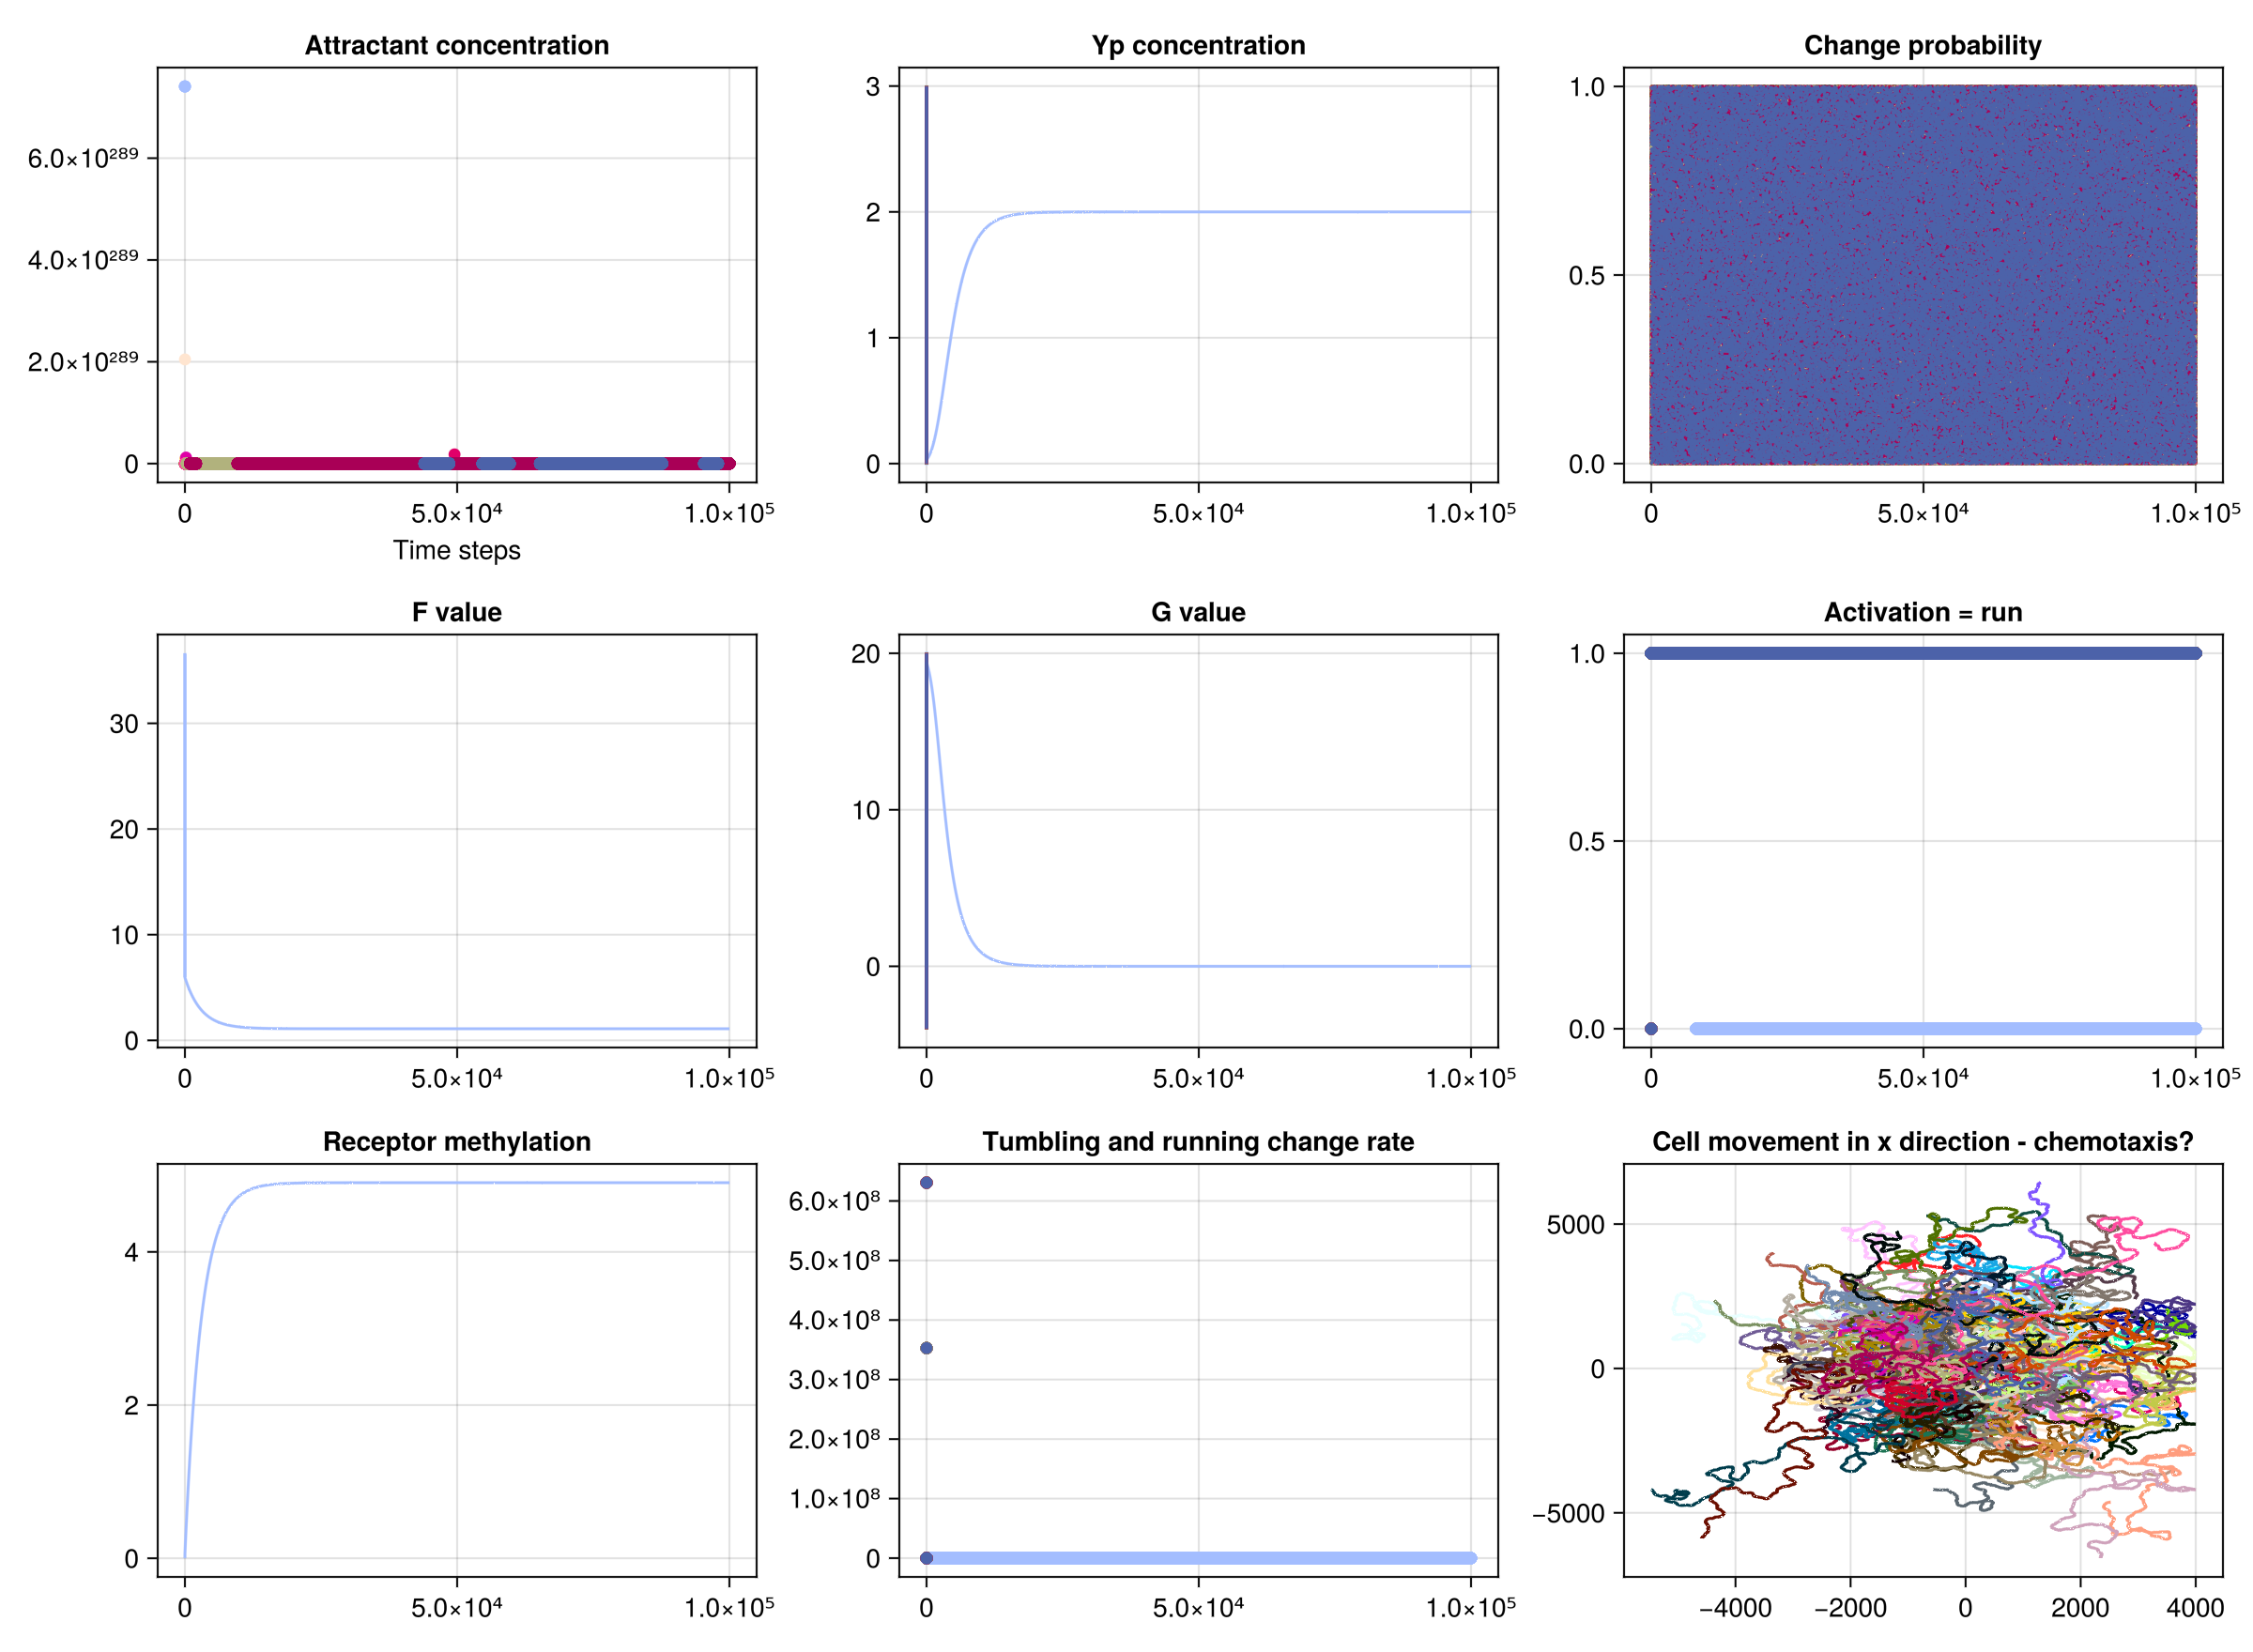

GLMakie.Screen(...)

In [34]:
using Colors
fig = Figure(size = (1200, 2500))

# Get unique cell IDs
cell_ids = unique(data.id)
n_cells = length(cell_ids)

# Generate fixed, distinguishable colors (same for all plots)
colors = distinguishable_colors(n_cells, [RGBf(0.2, 0.2, 0.2)], dropseed = true)

# Map id → color
id_to_color = Dict(cell_ids .=> colors)

ax0 = Axis(fig[1,1], title = "Attractant concentration", xlabel = "Time steps")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax0, group.step, group.M, color = id_to_color[id], label = "Cell $id")
end

# ylims!(ax0, 0.0, 10^30)

ax1 = Axis(fig[2,1], title = "F value" )

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax1, group.step, group.F, color = id_to_color[id], label = "Cell $id")
end


ax2 = Axis(fig[3,1], title = "Receptor methylation")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax2, group.step, group.methyl, color = id_to_color[id], label = "Cell $id")
end

ax3 = Axis(fig[1,2], title = "Yp concentration")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax3, group.step, group.Yp, color = id_to_color[id], label = "Cell $id")
end

ax4 = Axis(fig[2,2], title = "G value")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax4, group.step, group.G, color = id_to_color[id], label = "Cell $id")
end

ax5 = Axis(fig[3,2], title = "Tumbling and running change rate")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax5, group.step, group.λ, color = id_to_color[id], label = "Cell $id")
end

# ylims!(ax5, 0.0, 50)

ax6 = Axis(fig[1,3], title = "Change probability")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax6, group.step, group.P, color = id_to_color[id], label = "Cell $id", markersize = 2)
end

ax8 = Axis(fig[2,3], title = "Activation = run")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax8, group.step, group.active, color = id_to_color[id], label = "Cell $id")
end

ax7 = Axis(fig[3,3], title = "Cell movement in x direction - chemotaxis?")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax7, group.x, group.y, color = id_to_color[id], label = "Cell $id")
end


display(fig)

In [33]:
save("dufour_python_mm-2.png", fig)

In [28]:
#Group by step
grouped = groupby(data, :step)

#Compute mean and SEM
ensemble = combine(grouped,
    :Yp => mean => :Yp_mean,
    :Yp => std => :Yp_std,
    :F => mean => :F_mean,
    :F => std => :F_std,
    :methyl => mean => :methyl_mean,
    :methyl => std => :methyl_std,
    :x => mean => :x_mean,
    :x => std => :x_std,
    :M => mean => :M_mean,
    :M => std => :M_std
)

# Step 3: Add SEM columns
N = length(unique(data.id))
ensemble.Yp_sem = ensemble.Yp_std ./ sqrt(N)
ensemble.F_sem = ensemble.F_std ./ sqrt(N)
ensemble.methyl_sem = ensemble.methyl_std ./ sqrt(N)
ensemble.x_sem = ensemble.x_std ./ sqrt(N)
ensemble.M_sem = ensemble.M_std ./ sqrt(N)

# Step 4: Add time vector (if step is in seconds)
ensemble.t = ensemble.step .* 0.01  # adjust if dt is different

100000-element Vector{Float64}:
    0.01
    0.02
    0.03
    0.04
    0.05
    0.06
    0.07
    0.08
    0.09
    0.1
    ⋮
  999.9200000000001
  999.9300000000001
  999.94
  999.95
  999.96
  999.97
  999.98
  999.99
 1000.0

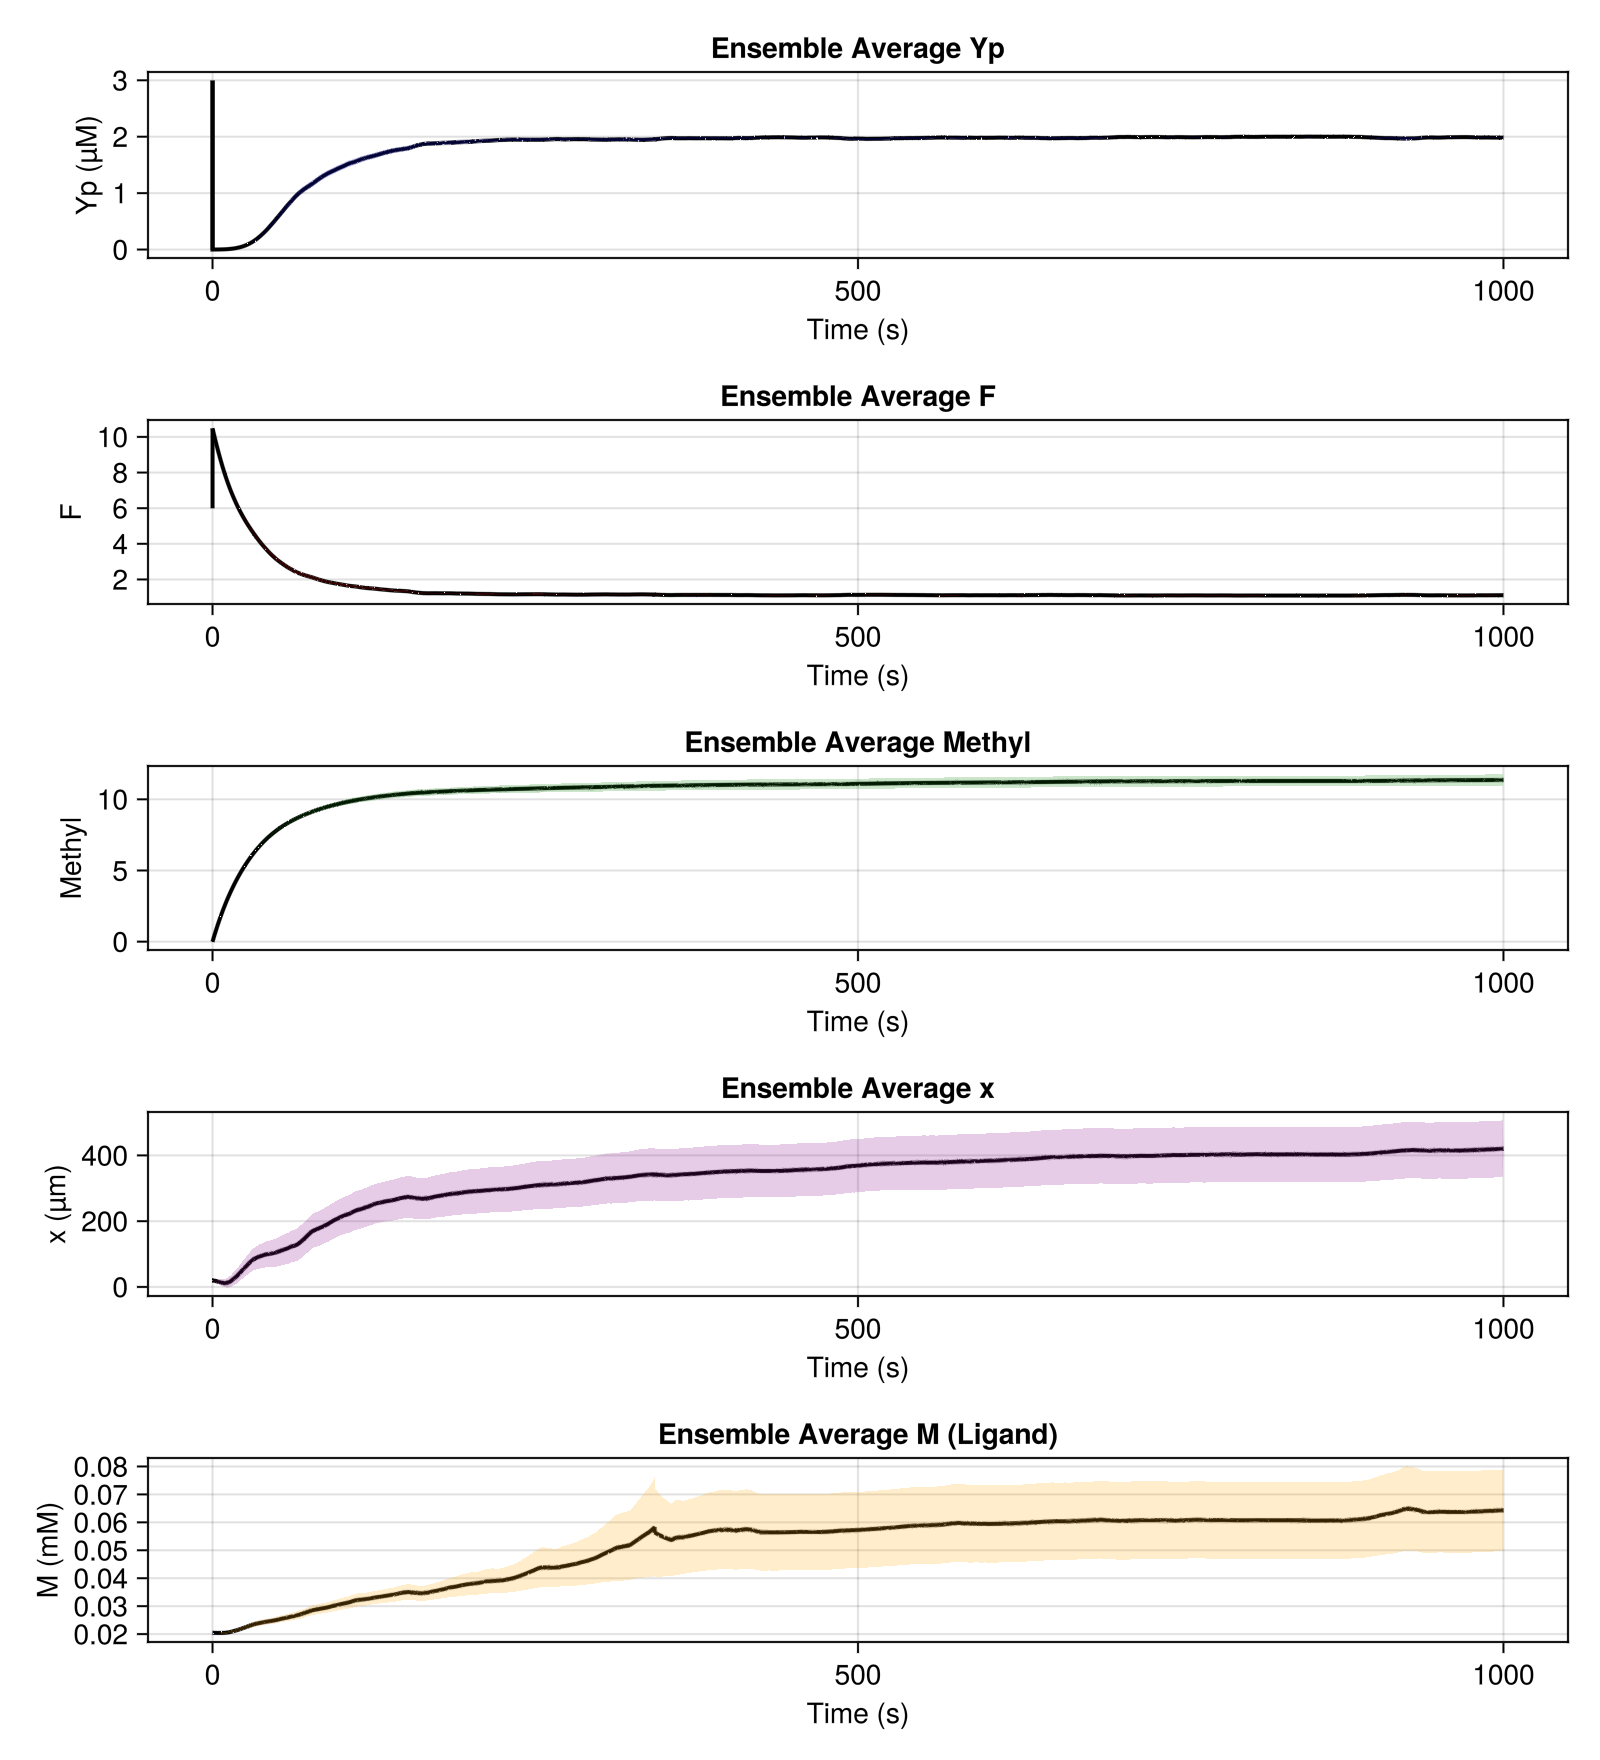

GLMakie.Screen(...)

In [29]:
fig = Figure(size=(800, 1000))

# Yp
ax1 = Axis(fig[1,1], title="Ensemble Average Yp", xlabel="Time (s)", ylabel="Yp (µM)")
lines!(ax1, ensemble.t, ensemble.Yp_mean, color=:black, linewidth=2)
band!(ax1, ensemble.t, ensemble.Yp_mean .- ensemble.Yp_sem, ensemble.Yp_mean .+ ensemble.Yp_sem, color=(:blue, 0.2))

# F
ax2 = Axis(fig[2,1], title="Ensemble Average F", xlabel="Time (s)", ylabel="F")
lines!(ax2, ensemble.t, ensemble.F_mean, color=:black, linewidth=2)
band!(ax2, ensemble.t, ensemble.F_mean .- ensemble.F_sem, ensemble.F_mean .+ ensemble.F_sem, color=(:red, 0.2))

# methyl
ax3 = Axis(fig[3,1], title="Ensemble Average Methyl", xlabel="Time (s)", ylabel="Methyl")
lines!(ax3, ensemble.t, ensemble.methyl_mean, color=:black, linewidth=2)
band!(ax3, ensemble.t, ensemble.methyl_mean .- ensemble.methyl_sem, ensemble.methyl_mean .+ ensemble.methyl_sem, color=(:green, 0.2))

# x (position)
ax4 = Axis(fig[4,1], title="Ensemble Average x", xlabel="Time (s)", ylabel="x (µm)")
lines!(ax4, ensemble.t, ensemble.x_mean, color=:black, linewidth=2)
band!(ax4, ensemble.t, ensemble.x_mean .- ensemble.x_sem, ensemble.x_mean .+ ensemble.x_sem, color=(:purple, 0.2))

# M (ligand concentration)
ax5 = Axis(fig[5,1], title="Ensemble Average M (Ligand)", xlabel="Time (s)", ylabel="M (mM)")
lines!(ax5, ensemble.t, ensemble.M_mean, color=:black, linewidth=2)
band!(ax5, ensemble.t, ensemble.M_mean .- ensemble.M_sem, ensemble.M_mean .+ ensemble.M_sem, color=(:orange, 0.2))

display(fig)


In [5]:
save("ensemble_average_2.png", fig)